In [200]:
import yfinance
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [201]:
data = yfinance.download("USDBRL=X", start="2020-01-01", end="2025-07-13", interval="1d")

C:\Users\mateu\AppData\Local\Temp\ipykernel_16616\1133883838.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yfinance.download("USDBRL=X", start="2020-01-01", end="2025-07-13", interval="1d")
[*********************100%***********************]  1 of 1 completed


In [202]:
data = data['Close']

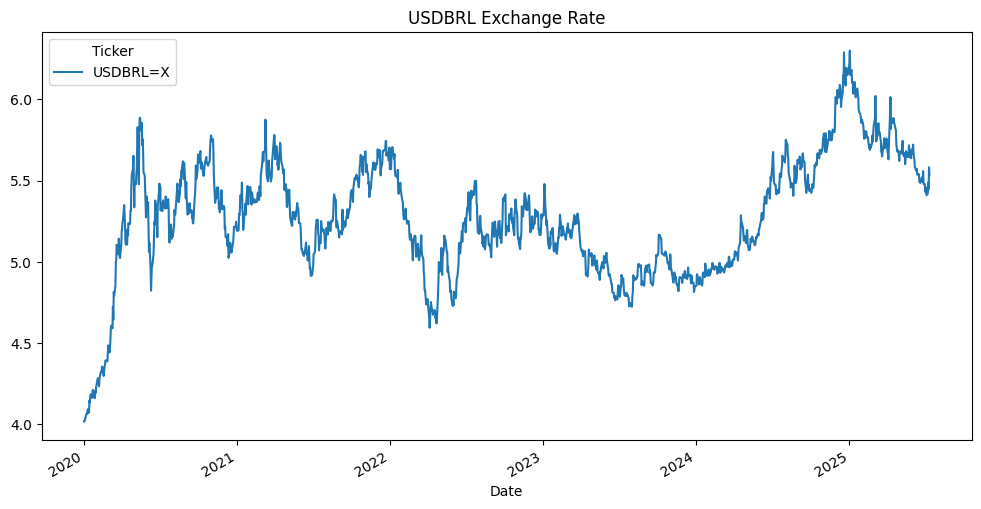

In [203]:
data.plot(figsize=(12, 6))
plt.title("USDBRL Exchange Rate")
plt.xlabel("Date")
plt.show()

In [204]:
data['mean'] = data['USDBRL=X'].rolling(window=50).mean()

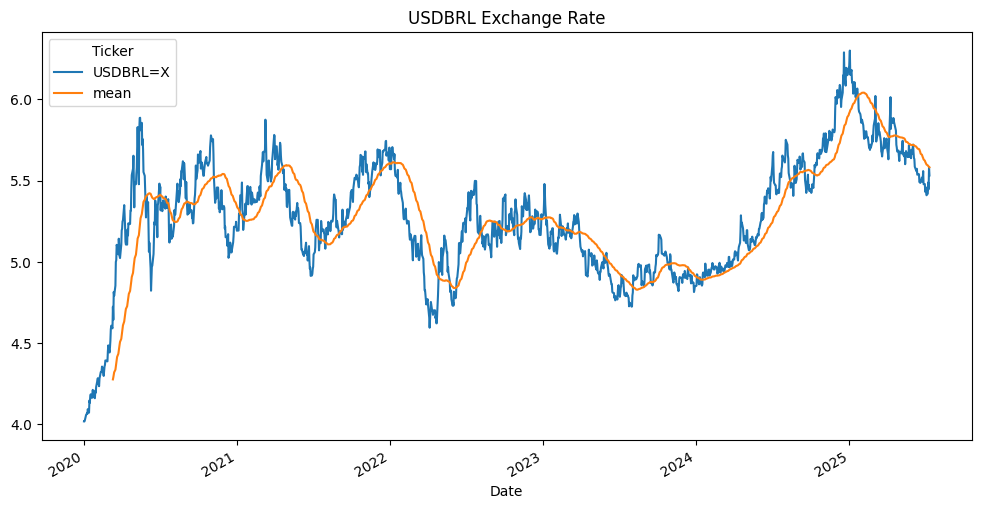

In [205]:
data.plot(figsize=(12, 6))
plt.title("USDBRL Exchange Rate")
plt.xlabel("Date")
plt.show()

In [206]:
# verificar se a serie é estacionária
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['USDBRL=X'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] < 0.05:
    print("A série é estacionária")
else:
    print("A série não é estacionária")

ADF Statistic: -3.758229173681506
p-value: 0.0033647937357304423
A série é estacionária


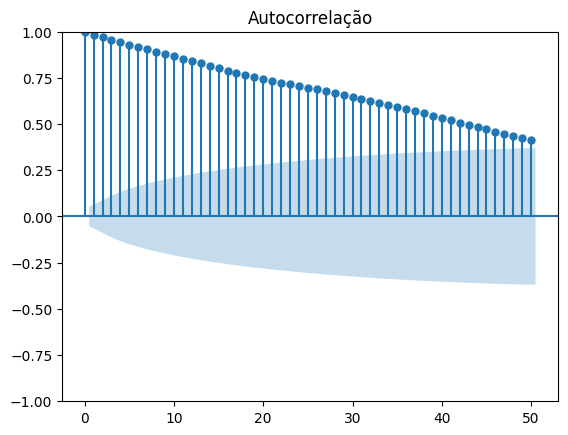

In [207]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['USDBRL=X'], lags=50)
plt.title("Autocorrelação")
plt.show()

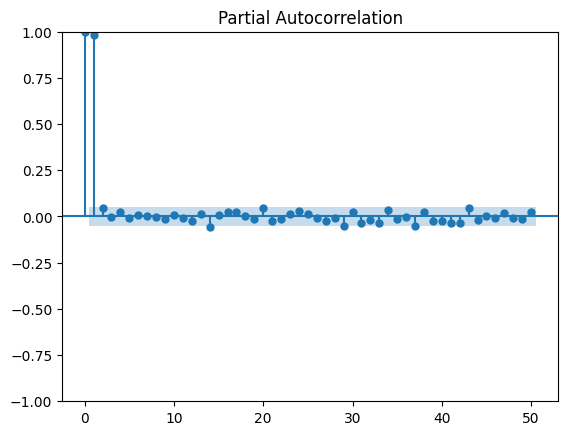

In [208]:
plot_pacf(data['USDBRL=X'], lags=50)
plt.show()

In [209]:
from statsmodels.tsa.stattools import kpss
kpss_result = kpss(data['USDBRL=X'])
print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])

if kpss_result[1] < 0.05:
    print("A série é estacionária")
else:
    print("A série não é estacionária")

KPSS Statistic: 0.7197058209382887
p-value: 0.011754016278337389
A série é estacionária


In [210]:
data['diff'] = data['USDBRL=X'].diff().apply(lambda x: 0 if pd.isna(x) else x)

<Axes: xlabel='Date'>

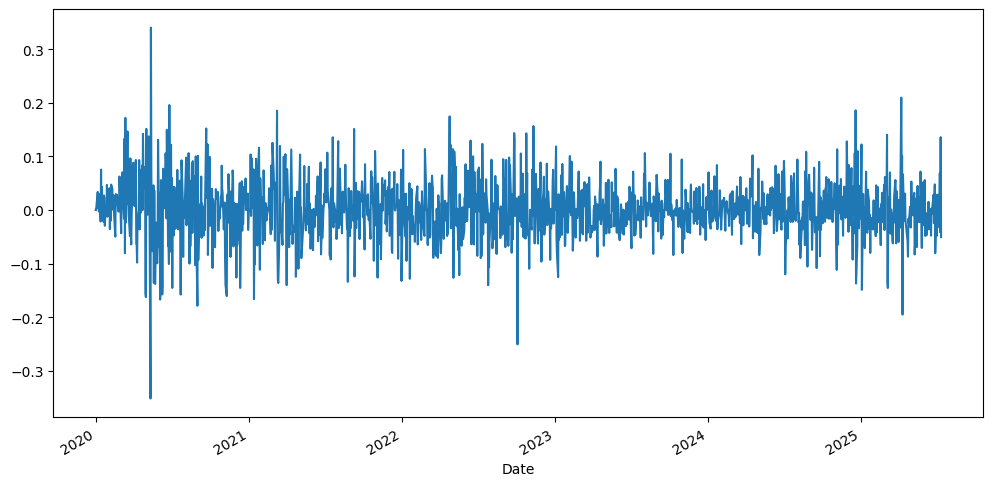

In [211]:
data['diff'].plot(figsize=(12, 6))

## Example 1

In [212]:
# timesgeneretor tensoflow
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

In [213]:
series = data['USDBRL=X'].values

In [214]:
scalar = MinMaxScaler()
series = scalar.fit_transform(series.reshape(-1, 1))

In [215]:
train_index = int(len(series) * 0.8)


# Split the data into training and testing sets
train = series[:train_index]
test  = series[train_index:]


# Create Timeseries Generators
train_generator = TimeseriesGenerator(
    train, train, length=40, batch_size=32
)
test_generator = TimeseriesGenerator(
    test, test, length=40, batch_size=32
)

total = TimeseriesGenerator(
    series, series, length=50, batch_size=32
)

In [216]:
1440/40

36.0

In [217]:
train_index-50

1102

In [218]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(50, input_shape=[None, 1], return_sequences=True),
    keras.layers.SimpleRNN(50, input_shape=[None, 1], return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1)),
])

c:\Users\mateu\Documents\Norton\Projetos GIT\livro-aprendizado-de-maquina-sklearn-keras-tf\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [219]:
lr = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.9)


model.compile(
    loss=keras.losses.mean_squared_error,
    optimizer=keras.optimizers.Adam(learning_rate=lr, clipvalue=1,use_ema=True),
    metrics=[keras.metrics.mean_absolute_error]
)

In [220]:
model.fit(
    train_generator,
    epochs=20,
    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=3)],
    validation_data=test_generator,
)

Epoch 1/20


c:\Users\mateu\Documents\Norton\Projetos GIT\livro-aprendizado-de-maquina-sklearn-keras-tf\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step - loss: 0.5674 - mean_absolute_error: 0.4566 - val_loss: 0.0096 - val_mean_absolute_error: 0.0725
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0265 - mean_absolute_error: 0.1349 - val_loss: 0.0474 - val_mean_absolute_error: 0.2032
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0144 - mean_absolute_error: 0.0884 - val_loss: 0.1405 - val_mean_absolute_error: 0.3653
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0349 - mean_absolute_error: 0.1554 - val_loss: 0.0185 - val_mean_absolute_error: 0.1144
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0145 - mean_absolute_error: 0.0980 - val_loss: 0.0267 - val_mean_absolute_error: 0.1453
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0099 - mean_absolute_error: 0.0823 - val_loss: 0.0463 - val_mean_absolute_error: 0.2011
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0105 - mean_absolute_error: 0.0825 - val_loss: 0.0062 

In [221]:
predicoes_completas = []

# Predições no treino
janela_tempo = 40

entrada_atual = series[:janela_tempo]


for i in range(len(series)-40):
    pred = model.predict(entrada_atual.reshape(1, janela_tempo, 1), verbose=0)
    predicoes_completas.append(pred[0, 0])
    entrada_atual = np.append(entrada_atual[1:], series[i + janela_tempo])

In [222]:
entrada_atual = series[-janela_tempo:]

predicoes_futuro = []
for _ in range(100):
    pred = model.predict(entrada_atual.reshape(1, janela_tempo, 1), verbose=0)
    predicoes_futuro.append(pred[0, 0])
    
    entrada_atual = np.append(entrada_atual[1:], pred[0, 0])
    entrada_atual = entrada_atual[-janela_tempo:]

In [223]:
len(predicoes_completas), len(series)

(1400, 1440)

In [224]:
ultimo_indice_real = len(series[40:]) - 1
indices_futuros = np.arange(ultimo_indice_real + 1, ultimo_indice_real + 1 + 100)

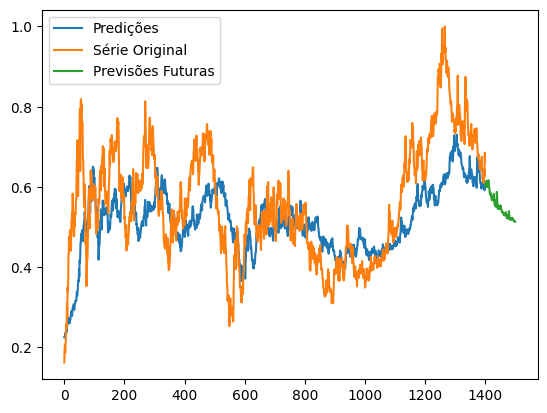

In [225]:
plt.plot(predicoes_completas, label='Predições')
plt.plot(series[40:], label='Série Original')
plt.plot(indices_futuros, predicoes_futuro, label='Previsões Futuras')
plt.legend()
plt.show()

### Exemplo 2

In [226]:
model = keras.models.Sequential([
    keras.layers.GRU(50, input_shape=[None, 1], return_sequences=True),
    keras.layers.GRU(50, input_shape=[None, 1], return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1)),
])
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_16 (GRU)                    │ (None, None, 50)       │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_17 (GRU)                    │ (None, None, 50)       │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, None, 1)        │            51 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

In [227]:
model.compile(
    loss=keras.losses.mean_squared_error,
    optimizer=keras.optimizers.Adam(learning_rate=lr, clipvalue=1,use_ema=True),
    metrics=[keras.metrics.mean_absolute_error]
)

In [228]:
series_total = TimeseriesGenerator(
    series, series, length=50, batch_size=32
)

In [229]:
history = model.fit(
    series_total,
    epochs=20,
    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=3)],
)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - loss: 0.0512 - mean_absolute_error: 0.1685
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0117 - mean_absolute_error: 0.0881
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 0.0144 - mean_absolute_error: 0.0970
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0164 - mean_absolute_error: 0.1046
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 0.0129 - mean_absolute_error: 0.0931
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.0112 - mean_absolute_error: 0.0862
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0149 - mean_absolute_error: 0.1015
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0139 - mean_absolute_error: 0.0997
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0119 - mean_absolute_error: 0.0849
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0140 - mean_absolute_error: 0.0974
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━

Plotando

In [230]:
janela_tempo = 50

In [231]:
predicoes_completas = []

pred = model.predict(series_total)

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step


In [ ]:
ultimo_ = series[-janela_tempo:]

predicoes_completas = []

for i in range(100):
    predict = model.predict(ultimo_.reshape(1, janela_tempo, 1), verbose=0)
    predicoes_completas.append(predict[0, 0])
    ultimo_ = np.append(ultimo_[1:], predict[0, 0])

In [ ]:
plt.plot(pred[:, 0, 0], label='Predições')
plt.plot(series[50:], label='Série Original')
plt.plot(np.arange(len(series[50:]), len(series[50:]) + len(predicoes_completas)), predicoes_completas, label='Previsões Futuras')
plt.legend()
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
inv_pred = scalar.inverse_transform(pred[:, -1, 0].reshape(-1, 1))
inv_series = scalar.inverse_transform(series.reshape(-1, 1))
inv_futuro = scalar.inverse_transform(np.array(predicoes_futuro).reshape(-1, 1))

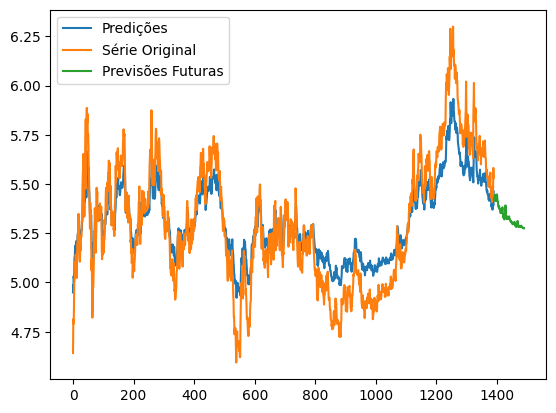

In [ ]:
plt.plot(inv_pred, label='Predições')
plt.plot(inv_series[50:], label='Série Original')
plt.plot(np.arange(len(inv_series[50:]), len(inv_series[50:]) + len(inv_futuro)), inv_futuro, label='Previsões Futuras')
plt.legend()
plt.show()

### Exemplo 3

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(50, input_shape=[None, 1], return_sequences=True),
    keras.layers.GRU(50),
    keras.layers.Dense(1),
])
model.summary()

c:\Users\mateu\Documents\Norton\Projetos GIT\livro-aprendizado-de-maquina-sklearn-keras-tf\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_14 (GRU)                    │ (None, None, 50)       │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_15 (GRU)                    │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    loss=keras.losses.mean_squared_error,
    optimizer=keras.optimizers.Adam(learning_rate=lr, clipvalue=1,use_ema=True),
    metrics=[keras.metrics.mean_absolute_error]
)

In [ ]:
sereis_total = TimeseriesGenerator(
    series, series, length=50, batch_size=32
)

In [ ]:
model.predict(series)

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 


array([[-1.2076725e-05],
       [ 0.0000000e+00],
       [-1.7646755e-04],
       ...,
       [-3.5817847e-02],
       [-3.9229151e-02],
       [-3.7954725e-02]], dtype=float32)

c:\Users\mateu\Documents\Norton\Projetos GIT\livro-aprendizado-de-maquina-sklearn-keras-tf\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


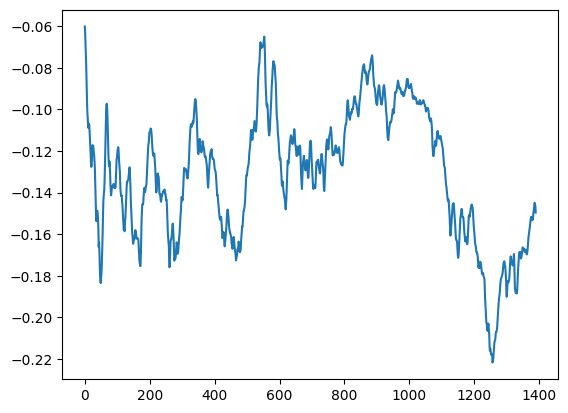

In [ ]:
plt.plot(model.predict(sereis_total), label='Predições')

### Exemplo 4

In [ ]:
def gerador_dados(series, janela_tempo=50):
    X = []
    y = []
    for i in range(len(series) - janela_tempo):
        Xi = series[i:i + janela_tempo].reshape(-1, 1)
        yi =series[i + janela_tempo].reshape(-1, 1)
        X.append(Xi)
        y.append(yi)
    return np.array(X), np.array(y)

In [ ]:
X, y = gerador_dados(series, janela_tempo=50)

In [ ]:
index_train = int(len(X) * 0.8)

In [ ]:
xtrain, xtest, ytrain, ytest = (
    X[:train_index - 50], X[train_index - 50:],
    y[:train_index - 50], y[train_index - 50:]
)

In [ ]:
xtrain_rnn = xtrain.reshape(xtrain.shape[0], xtrain.shape[1], 1)
xtest_rnn = xtest.reshape(xtest.shape[0], xtest.shape[1], 1)

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(50, input_shape=[None, 1], return_sequences=True),
    keras.layers.LSTM(50, return_sequences=False),
    keras.layers.Dense(1),
])

c:\Users\mateu\Documents\Norton\Projetos GIT\livro-aprendizado-de-maquina-sklearn-keras-tf\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(
    loss=keras.losses.mean_squared_error,
    optimizer=keras.optimizers.Adam(learning_rate=lr, clipvalue=1, use_ema=True),
    metrics=[keras.metrics.mean_absolute_error]
)

In [ ]:
model.fit(
    xtrain_rnn, ytrain,
    epochs=20,
    validation_data=(xtest_rnn, ytest),
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
)

Epoch 1/20


35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0881 - mean_absolute_error: 0.2214 - val_loss: 0.0126 - val_mean_absolute_error: 0.0933
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0045 - mean_absolute_error: 0.0544 - val_loss: 0.0027 - val_mean_absolute_error: 0.0402
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0023 - mean_absolute_error: 0.0376 - val_loss: 0.0038 - val_mean_absolute_error: 0.0515
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0021 - mean_absolute_error: 0.0359 - val_loss: 0.0039 - val_mean_absolute_error: 0.0537
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0020 - mean_absolute_error: 0.0339 - val_loss: 0.0015 - val_mean_absolute_error: 0.0304
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0016 - mean_absolute_error: 0.0309 - val_loss: 0.0029 - val_mean_absolute_error: 0.0456
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0015 - mean_absolute_error: 0.0303 - val_loss: 0.0011 - 

In [ ]:
# Predict
ypred_rnn = model.predict(xtest_rnn)

ypred_rnn.shape

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


(288, 1)

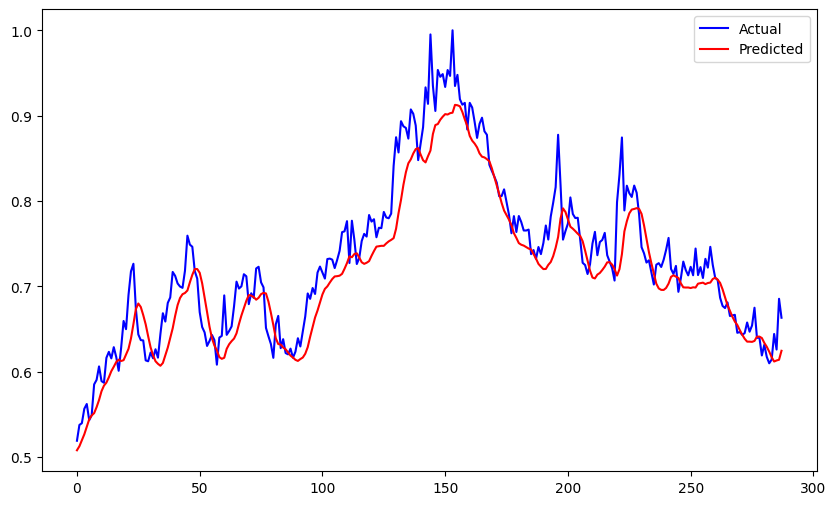

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(ytest.reshape(-1, 1), label='Actual', color='Blue')
plt.plot(ypred_rnn, label='Predicted', color='Red')
plt.legend()
plt.savefig("RNN_forecast.png")
plt.show()

In [ ]:
pred_train = model.predict(xtrain_rnn)
pred_train.shape

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


(1102, 1)

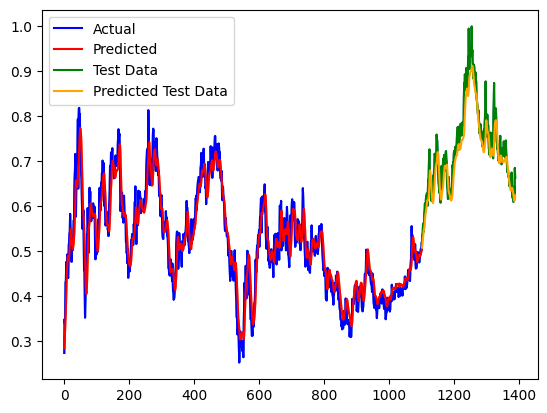

In [ ]:
plt.plot(series[50:])
plt.plot(pred_train)
plt.plot(ytrain.reshape(-1, 1), label='Actual', color='Blue')
plt.plot(pred_train, label='Predicted', color='Red')
#ytest

plt.plot(range(len(ytrain), len(ytrain) + len(ypred_rnn)), ytest.reshape(-1, 1), label='Test Data', color='Green')
plt.plot(range(len(ytrain), len(ytrain) + len(ypred_rnn)), ypred_rnn, label='Predicted Test Data', color='Orange')

#
plt
plt.legend()
plt.show()